Recurrent spillover branching process (infinite population), plots probabilities of outbreak (??)

TO DO: clarify what probability of outbreak even means here. 
In the code, extinction means a time when nobody is infected. Outbreak is when number of infecteds hits a threshold. Probability of outbreak means probability of hitting the latter before the former. Is this a sensible notion for this context??

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#THE RECURRENT SPILLOVER FUNCTION NEEDS TO CALL THIS SINGLE SPILLOVER FUNCTION

###################################################
# simulates infection WITHOUT recurrent spillover 
# allows both gamma and beta to mutate            
#
# note: this implementation branches people in "generation order" instead of in "time order"
# (faster to run, and still gives the same result in the limit as outbreak_thresh -> infinity)
# for an implementation done in time order, see the function sim_class
#
# also note that if the infection goes extinct the time of extinction is well-defined, and either implementation computes it correctly.
###################################################
#
# input beta_0 is transmission rate of the initial case.
# input gamma_0 is recovery rate of the initial case. 
#
# optional input mu_1 represents mutation rate for beta. If unspecified, defaults to 0.
# optional input mu_2 represents mutation rate for gamma. If unspecified, defaults to 0.
#
###################################################
#
# returns 0, t_ext if extinction, where t_ext is time of extinction. 
# returns 1 if outbreak
#
###################################################

def sim(beta_0, gamma_0, mu_1=0, mu_2=0):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    t = 0
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=[[beta_0, gamma_0, t]]
    
    N_infected = len(infecteds) #keep track of number of infected people
    
    t_ext = None #time of extinction, will fill this value and return it if the infection goes extinct
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        #keeps track of indices of recovered people
        #will delete them from array of infecteds at the end of each while loop iteration
        recovereds = []
        
        for i, person in enumerate(infecteds): #go through and branch each person in array of infecteds

            #print("\n", "branching person", i)
            
            [beta, gamma, t] = person
            
            while True:
                                
                #interevent time
                #note this is interevent time for ONE person, NOT for entire population
                dt = np.random.exponential(scale = 1/(beta + gamma))
                new_t = t + dt #time of new event
                
                #pick which new event happens, transmission or recovery         
                ev = np.random.rand() #draw number from uniform distribution over [0, 1)
                prob_trans = beta / (beta+gamma)

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    #pick beta and gamma for new case
                    #mutation is a number drawn from normal distribution with std dev mu_1 or mu_2
                    #don't allow negative beta.
                    #don't allow gamma to be less than a small value, the natural death rate.
                    mut1 = np.random.normal(loc=0.0, scale=mu_1)
                    new_beta = max(0, beta + mut1)
                    mut2 = np.random.normal(loc=0.0, scale=mu_2)              
                    nat_death = 0.00002366575 #taken from CDC: https://www.cdc.gov/nchs/fastats/deaths.htm & scaled to be daily rate instead of yearly
                    new_gamma = max(nat_death, gamma + mut2)
                    
                    #append new person to array of infecteds
                    infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                    N_infected += 1
                    
                    if N_infected >= outbreak_thresh:
                        #print("\n", "outbreak!")
                        return 1

                    #print("new infection: ", [new_beta, new_gamma, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
 
                    if N_infected == 0:
                        #print("\n", "extinction")
                        return 0, new_t
                    
                    #mark index of this recovered person, in order to delete them later
                    #(we don't delete yet, because that will mess up the indexing of the for loop)
                    recovereds.append(i)
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #update the array of infecteds by deleting recoveries
        infecteds = np.delete(infecteds, recovereds, axis=0)

In [8]:
################################################
# simulates infection WITH recurrent spillover 
#
# this implementation is in "generation order" since it calls on the function sim.
# furthermore, each entire spillover tree is simulated before moving on to the next tree.
# for a "time order" implementation, see recurrent_sim_class.
#
################################################
#
# input alpha = spillover rate.
#
# inputs beta_0, gamma_0, mu_1, mu_2 are the same as in the function sim from above
#
# there are two hidden inputs max_t_ext, t_s, which you should ignore. (do NOT pass in any values for these.)
# they are only used implicitly when this function recursively calls itself.
#
################################################
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################
#
# TO DO: when alpha > 0, there may be the possibility of endemicity. 
# Right now, this function only terminates at outbreak or extinction. Need to fix this in the future.
# See recurrent_sim_class for an implementation which terminates after a certain maximum simulated number of days.
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0, mu_2=0, max_t_ext=0, t_s=0): 
    
    # hidden input max_t_ext keeps track of maximum extinction time seen so far
    # hidden input t_s keeps track of most recent time of spillover
    
    # simulate tree from a new spillover event
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    # if it outbreaks, we are done
    if sim_output == 1:
        
        #print("\n", "outbreak!")
        return 1
    
    # otherwise, that tree goes extinct
    # but we need to check whether any other spillovers happened in the meantime
    else:
        
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
       #if alpha is 0, no more spillovers ever occur. we are done.
        if alpha == 0: 
            return 0
        
        #otherwise, generate time of next spillover
        dt_s = np.random.exponential(scale=1/alpha) #inter-spillover time
        t_s += dt_s #time of next spillover
        #print("time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, we have to simulate another tree. recurse.
        if t_s < max_t_ext: 
            
            #print("a spillover occured! Recursing...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, we are done.
        else: 
            
            #print("next spillover too late. extinction!")
            return 0

In [9]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0, mu_2 = 0, N_sims=100): 
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [10]:
# run a single simulation

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [11]:
%%time
# run a bulk simulation

#parameters
alpha = 0.01
beta_0 = 0.09
gamma_0 = 0.01
mu_1=0.001
mu_1=0.001

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1, mu_1, N_sims=1000)

CPU times: user 1.88 s, sys: 21.6 ms, total: 1.9 s
Wall time: 1.92 s


0.886

In [12]:
###########################################################################
# for a fixed mu and alpha, plots the probability of outbreak against R_0 #
###########################################################################
#
# input alpha
# input mu = mu_1 = mu_2
#
# optional inputs R0_min, R0_max give range of R_0 to plot over.
# optional input N_points gives number of points to plot.
# optional inputs N_sims gives number of simulations to run per point.
#
##########################################################################

def recurrent_prob_plot(alpha, mu, R0_min=0.001, R0_max=2.5, N_points = 75, N_sims=750):
    
    # Take some evenly spaced R_0 values
    # Note that it does matter what beta and gamma are, even if they give the same R_0. 
    # But here we're just fixing gamma to be 0.1
    # TO DO later: explore other choices.
    beta_range = np.linspace(R0_min/10, R0_max/10, N_points); gamma = 0.1
    
    # initialize arrays to be plotted
    R0 = []; percent = []

    #simulate percentages of outbreak
    for beta in beta_range:
        R0 = np.append(R0, beta/gamma)
        percent = np.append(percent, recurrent_sim_percentage(alpha, beta, gamma, mu, mu, N_sims))
        
    #make the plot
    plt.plot(R0, percent, "ob")
    #graph the actual probability of outbreak with no mutation and no recurrent spillover
    #####################################################################################
    # From Linda's talk:
    #                            0 if R_0 < 1
    #                            1-1/R_0 = 1-gamma/beta if R_0 > 1
    #####################################################################################
    plt.plot(R0, np.piecewise(R0, [R0<1, R0>=1], [0, lambda R0: 1-1/R0]), "r", label='probability without mutation')
    plt.title('alpha = {}, mu1 = mu2 = {}'.format(alpha, mu))
    plt.xlabel("R_0"); plt.ylabel("p")
    plt.xlim(R0_min, R0_max)
    plt.legend()
    plt.show()

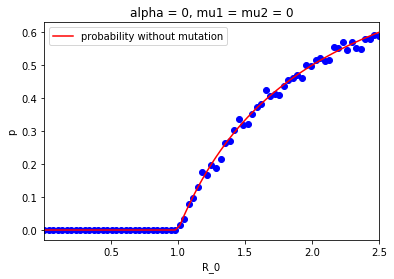

CPU times: user 1min 27s, sys: 821 ms, total: 1min 28s
Wall time: 1min 30s


In [13]:
%%time 

#########################
# SANITY CHECK 2 
# When there is no mutation, and no spillover, check that our simulation agrees with known results.
#########################

recurrent_prob_plot(alpha=0, mu=0)

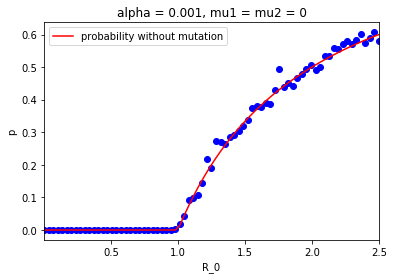

CPU times: user 1min 47s, sys: 1.05 s, total: 1min 48s
Wall time: 1min 53s


In [14]:
%%time
recurrent_prob_plot(alpha=0.001, mu=0)

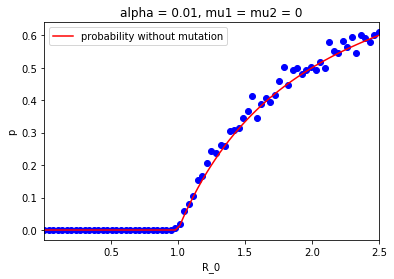

CPU times: user 1min 48s, sys: 1.04 s, total: 1min 49s
Wall time: 1min 56s


In [15]:
%%time
recurrent_prob_plot(alpha=0.01, mu=0)

In [ ]:
%%time
recurrent_prob_plot(alpha=0.1, mu=0)